## Cодержание:
* [Импорт библиотек](#first)
* [Загрузка и изучение данных](#second)
* [Базовый анализ данных](#third)
* [Предобработка данных](#fourth)
* [Обучение модели](#fifth)
* [Тестирование модели](#sixth)
* [Выводы](#seventh)

## Импорт библиотек <a class="anchor" id="first"></a>

In [1]:
pip install pymorphy2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 965.5 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 28.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import pandas as pd

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from typing import Optional

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import pymorphy2
from sklearn.utils import resample

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier




import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F
# TorchText development is stopped and the 0.18 release (April 2024) will be the last stable release of the library.
import torchtext




import time

import re


RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device(type='cuda', index=0)

## Загрузка данных <a class="anchor" id="second"></a>

Geo Reviews Dataset 2023 - https://github.com/yandex/geo-reviews-dataset-2023


In [3]:
df = pd.read_csv('/kaggle/input/sentimentanalysisyandexreviews/lem_500kdata.csv', index_col=0)

In [4]:
df.head()

,rating,text
0,3,московский квартал шумно лето ночь дикий гонка...
1,5,замечательный сеть магазин общий хороший ассор...
2,1,знать смутить коготь дать правило удивить хоте...
3,4,хороший условие аренда дружелюбный персонално ...
4,5,топ мастер ангелина топ смысл немного волноват...


## Подготовка данных для обучения модели

### Баланс классов

У нас большой датасет и минорный класс имеет `2` имеет 12071 отзыв, так что я возьму у каждого класса по 50000 отызвов.

In [10]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct


def get_plt_value_counts(Series: pd.Series) -> None:

    value_counts = Series.value_counts()

    plt.figure(figsize=(4, 4))
    plt.pie(value_counts, labels=value_counts.index,
            autopct=make_autopct(value_counts), startangle=30)
    plt.axis('equal')
    plt.title('Распределение отзывов по оценке')

    plt.show()


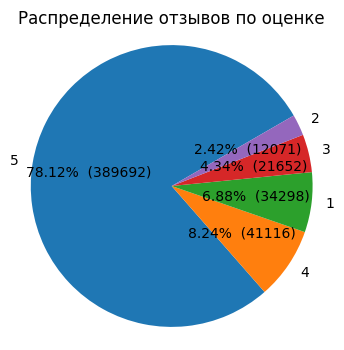

In [11]:
get_plt_value_counts(df['rating'])

In [12]:
def get_balanced_df(df: pd.DataFrame, size) -> pd.DataFrame:
    class_1 = df[df['rating'] == 1]
    class_2 = df[df['rating'] == 2]
    class_3 = df[df['rating'] == 3]
    class_4 = df[df['rating'] == 4]
    class_5 = df[df['rating'] == 5]

    class_1_undersampled = resample(class_1, replace=True, n_samples=size)
    class_2_undersampled = resample(class_2, replace=True, n_samples=size)
    class_3_undersampled = resample(class_3, replace=True, n_samples=size)
    class_4_undersampled = resample(class_4, replace=True, n_samples=size)
    class_5_undersampled = resample(class_5, replace=False, n_samples=size)

    new_df = pd.concat([class_1_undersampled, class_2_undersampled,class_3_undersampled, class_4_undersampled, class_5_undersampled])
    return new_df['text'], new_df['rating']

### Делим выборку на train и test

In [13]:
df['text'] = df['text'].fillna('')
df['rating'] = df['rating'].fillna('')

X = df['text']
y = df['rating']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_b, y_train_b = get_balanced_df(pd.concat([X_train, y_train], axis=1), 50000)

Делим выборку перед векторизацией, что бы избежать утечки данных при тесте.

### Векторизация

Я пробывал два способа векторизации. tfidf - обучался быстрее и показывал лучше точность. 

Здесь я использую параметры: 
1. min_df= 1  - я хотел убрать редко встречаемые слова и слова написаные с ошибкой, чтобы повысило точность модели. И оно повысилось. Но если мы ставим 1 с ngram_range=(1, 3) работает отлично.
2. max_df=0.95 - здесь беру слова которые в 95% документах, избавляюсь от частых слов.
3. ngram_range=(1, 3) - для учета словосочетаний.

In [58]:
def get_tfidf_vectorized(X_train,X_test) -> tuple[pd.Series, pd.Series]:
    tfidf_vectorizer = TfidfVectorizer(
#         min_df=1,
         binary=False, max_features=7000)

    X_train.fillna('', inplace=True)
    X_test.fillna('', inplace=True)


    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return tfidf_vectorizer, X_train_tfidf, X_test_tfidf


In [15]:
X_train_tfidf, X_test_tfidf = get_tfidf_vectorized(X_train, X_test)

print('Tfidf_train:', X_train_tfidf.shape)
print('Tfidf_test:', X_test_tfidf.shape)

Tfidf_train: (399063, 7000)
Tfidf_test: (99766, 7000)


In [59]:
tfidf_vectorizer, X_train_b_tfidf, X_test_tfidf = get_tfidf_vectorized(X_train_b, X_test)

print('Tfidf_train:', X_train_b_tfidf.shape)
print('Tfidf_test:', X_test_tfidf.shape)

Tfidf_train: (250000, 7000)
Tfidf_test: (99766, 7000)


## Обучение моделей <a class="anchor" id="fifth"></a>

### Функции обучения

In [26]:
def get_confusion_matrix(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues",
                xticklabels=[1, 2, 3, 4, 5],
                yticklabels=[1, 2, 3, 4, 5])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [19]:
def train_ml(model, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)
    get_confusion_matrix(y_test, y_pred)


### Запуск обучения

MultinomialNB

In [55]:
X_test_tfidf

<99766x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 2361869 stored elements in Compressed Sparse Row format>

In [56]:
X_test_tfidf

<99766x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 2361869 stored elements in Compressed Sparse Row format>

Training_time : 0.09195256233215332
Test_time : 0.01652359962463379
              precision    recall  f1-score   support

           1       0.08      0.07      0.08      6822
           2       0.08      0.06      0.07      2367
           3       0.07      0.05      0.06      4365
           4       0.09      0.01      0.02      8273
           5       0.79      0.90      0.84     77939

    accuracy                           0.71     99766
   macro avg       0.22      0.22      0.21     99766
weighted avg       0.64      0.71      0.67     99766



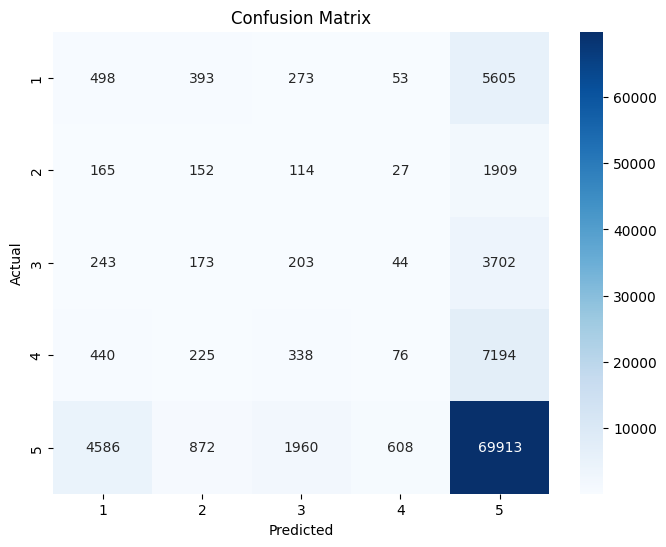

In [57]:
naive_bayes = MultinomialNB()


train_ml(naive_bayes, X_train_tfidf, y_train, X_test_tfidf, y_test)

Training_time : 0.06888914108276367
Test_time : 0.016689300537109375
              precision    recall  f1-score   support

           1       0.51      0.66      0.58      6822
           2       0.16      0.29      0.21      2367
           3       0.23      0.31      0.26      4365
           4       0.21      0.58      0.30      8273
           5       0.97      0.72      0.83     77939

    accuracy                           0.68     99766
   macro avg       0.42      0.51      0.44     99766
weighted avg       0.83      0.68      0.73     99766



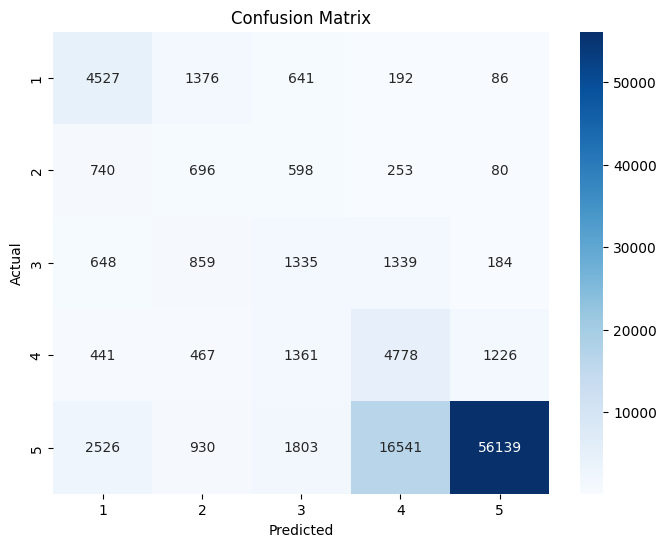

In [58]:
naive_bayes_b = MultinomialNB()


train_ml(naive_bayes_b, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

LogisticRegression

Training_time : 12.38243579864502
Test_time : 0.016640424728393555
              precision    recall  f1-score   support

           1       0.07      0.14      0.09      6822
           2       0.07      0.01      0.01      2367
           3       0.05      0.05      0.05      4365
           4       0.10      0.04      0.05      8273
           5       0.78      0.78      0.78     77939

    accuracy                           0.62     99766
   macro avg       0.21      0.20      0.20     99766
weighted avg       0.62      0.62      0.62     99766



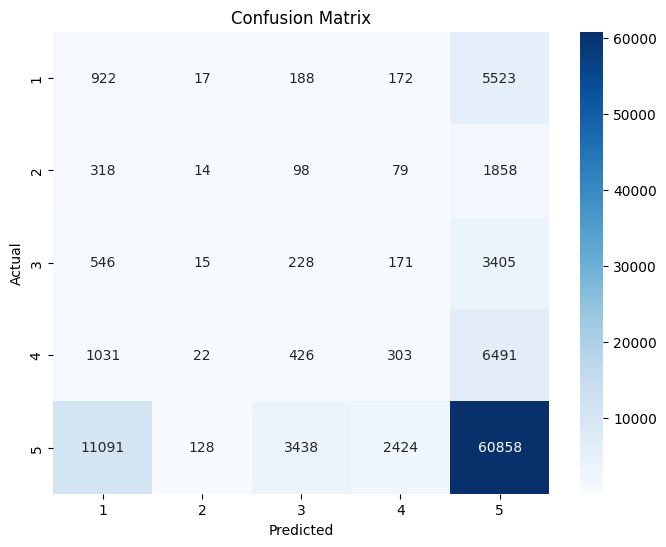

In [60]:
logistic_classifier = LogisticRegression(
    solver='saga',
    max_iter=1000,
    multi_class='multinomial',
    penalty='l2',
    C=1.0,
    random_state=42
)



train_ml(logistic_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test)

Training_time : 10.670564651489258
Test_time : 0.016755342483520508
              precision    recall  f1-score   support

           1       0.64      0.66      0.65      6822
           2       0.16      0.33      0.22      2367
           3       0.22      0.35      0.27      4365
           4       0.25      0.52      0.34      8273
           5       0.97      0.80      0.88     77939

    accuracy                           0.73     99766
   macro avg       0.45      0.53      0.47     99766
weighted avg       0.84      0.73      0.77     99766



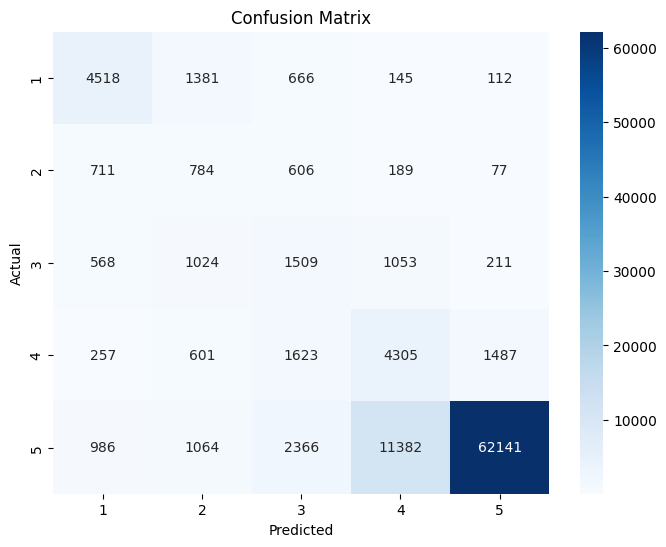

In [61]:
logistic_classifier = LogisticRegression(
    solver='saga',
    max_iter=1000,
    multi_class='multinomial',
    penalty='l2',
    C=1.0,
    random_state=42
)



train_ml(logistic_classifier, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

RandomForestClassifier

In [ ]:
random_forest = RandomForestClassifier(
    n_estimators=40,
    criterion='gini',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42
)

train_ml(random_forest, X_train_tfidf, y_train, X_test_tfidf, y_test)

Training_time : 239.82870244979858
Test_time : 1.6787114143371582
              precision    recall  f1-score   support

           1       0.47      0.81      0.60      6822
           2       0.15      0.06      0.09      2367
           3       0.20      0.24      0.21      4365
           4       0.24      0.50      0.33      8273
           5       0.95      0.79      0.86     77939

    accuracy                           0.73     99766
   macro avg       0.40      0.48      0.42     99766
weighted avg       0.81      0.73      0.75     99766



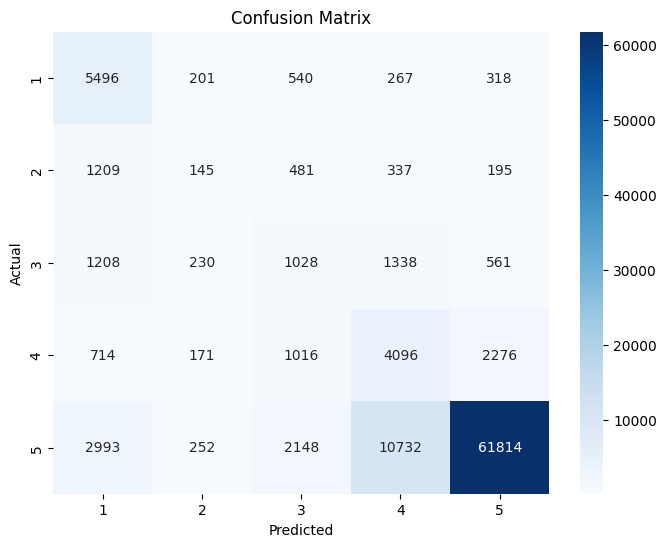

In [63]:
random_forest = RandomForestClassifier(
    n_estimators=40,
    criterion='gini',
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=5,
    random_state=42
)

train_ml(random_forest, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

CatBoostClassifier

In [63]:
def train_catboost(model: CatBoostClassifier,
                   X_train: pd.DataFrame, y_train: pd.Series,
                   X_test: pd.DataFrame, y_test: pd.Series,
                   model_name: str,
                   verbose_step: int = 100) -> pd.DataFrame:

    start_time = time.time()
    model.fit(
        X_train, y_train,                   # обучающая выборка
        eval_set=(X_test, y_test),            # тестовая выборка
        verbose=verbose_step                         # шаг вывода статуса модели
    )
    training_time = time.time() - start_time

    model.save_model(f'{model_name}.json')
    feature_importance = model.get_feature_importance(prettified=True)

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)
    get_confusion_matrix(y_test, y_pred)

0:	learn: 1.5886210	test: 1.5668023	best: 1.5668023 (0)	total: 614ms	remaining: 10m 13s
100:	learn: 1.2628052	test: 1.0650686	best: 1.0650686 (100)	total: 28.5s	remaining: 4m 13s
200:	learn: 1.1850975	test: 0.9682772	best: 0.9682772 (200)	total: 53.3s	remaining: 3m 32s
300:	learn: 1.1389625	test: 0.9157464	best: 0.9157464 (300)	total: 1m 17s	remaining: 2m 59s
400:	learn: 1.1064014	test: 0.8825126	best: 0.8825126 (400)	total: 1m 40s	remaining: 2m 29s
500:	learn: 1.0817059	test: 0.8594567	best: 0.8594567 (500)	total: 2m 3s	remaining: 2m 2s
600:	learn: 1.0616066	test: 0.8438032	best: 0.8438032 (600)	total: 2m 25s	remaining: 1m 36s
700:	learn: 1.0446183	test: 0.8311929	best: 0.8311929 (700)	total: 2m 47s	remaining: 1m 11s
800:	learn: 1.0300494	test: 0.8213259	best: 0.8213259 (800)	total: 3m 9s	remaining: 47.1s
900:	learn: 1.0173377	test: 0.8134683	best: 0.8134683 (900)	total: 3m 31s	remaining: 23.2s
999:	learn: 1.0056283	test: 0.8064786	best: 0.8064786 (999)	total: 3m 52s	remaining: 0us
be

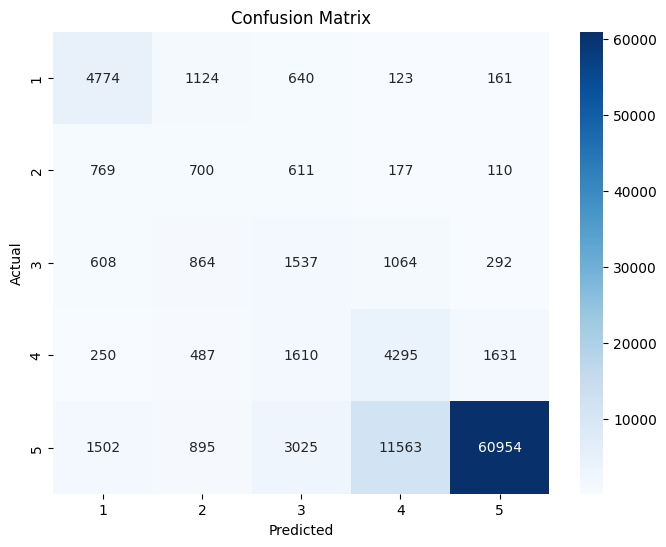

In [64]:
# архитектура модели
catboost_model_b = CatBoostClassifier(
    iterations=1000,            # кол-во итераций обучения
    depth=6,                    # рекомендованная глубина модели
    learning_rate=0.075,        # скорость обучения
    random_seed=47,             # сид для воспроизводимости результата
    loss_function='MultiClass', # тип модели или функция ошибки
    task_type="GPU",            # обучение на видеокарте
    devices='0',
    early_stopping_rounds=20    # регуляризация ранней остановкой в случае
    )


train_catboost(catboost_model_b, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test, model_name = 'catboost_model')

LGBMClassifier

In [35]:
def train_lgbm(model: lgb.LGBMClassifier,
                   X_train: pd.DataFrame, y_train: pd.Series,
                   X_test: pd.DataFrame, y_test: pd.Series):

    start_time = time.time()
    model.fit(
        X_train, y_train,                   # обучающая выборка
        eval_set=(X_test, y_test),            # тестовая выборка
    )
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)
    get_confusion_matrix(y_test, y_pred)

Training_time : 104.91574835777283
Test_time : 1.99680757522583
              precision    recall  f1-score   support

           1       0.56      0.68      0.61      6822
           2       0.11      0.29      0.16      2367
           3       0.17      0.28      0.21      4365
           4       0.23      0.50      0.31      8273
           5       0.96      0.74      0.83     77939

    accuracy                           0.68     99766
   macro avg       0.41      0.50      0.43     99766
weighted avg       0.82      0.68      0.73     99766



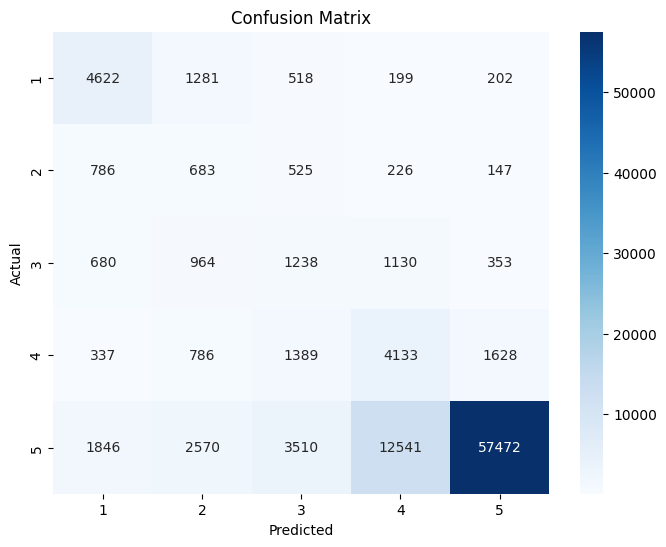

In [46]:
lgbm_model = lgb.LGBMClassifier(n_estimators=100, max_depth=7, num_leaves = 128, verbosity= -1, random_state=42, n_jobs=-1, device = 'gpu', objective = 'multiclass',early_stopping_rounds=20)

train_lgbm(lgbm_model, X_train_b_tfidf, y_train_b, X_test_tfidf, y_test)

XGBClassifier

In [52]:
def train_xgb(model: xgb.XGBClassifier,
                   X_train: pd.DataFrame, y_train: pd.Series,
                   X_test: pd.DataFrame, y_test: pd.Series):

    start_time = time.time()
    model.fit(
        X_train, y_train
    )
    training_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    test_time = time.time() - start_time

    cr = classification_report(y_test, y_pred)
    print(f"Training_time : {training_time}")
    print(f"Test_time : {test_time}")

    print(cr)

In [55]:
xgb_model = xgb.XGBClassifier(max_depth=7, num_leaves = 128, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist',  num_class=5, objective='multi:softmax')

train_xgb(xgb_model, X_train_b_tfidf, y_train_b - 1, X_test_tfidf, y_test - 1)

Training_time : 16.37905216217041
Test_time : 0.07608437538146973
              precision    recall  f1-score   support

           0       0.07      0.27      0.11      6822
           1       0.03      0.36      0.06      2367
           2       0.04      0.06      0.04      4365
           3       0.08      0.37      0.13      8273
           4       0.95      0.01      0.02     77939

    accuracy                           0.07     99766
   macro avg       0.23      0.21      0.07     99766
weighted avg       0.75      0.07      0.04     99766



Вывод: результаты средние. Для лучшего скора идем в DL. 2.1-model

## Проверка отзывов

In [67]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

morph = pymorphy2.MorphAnalyzer()


def analyze_sentiment(text):
    original_text = text
    text = text.lower()
    text = re.sub(r'[^а-яА-Я ]', '', text)
    text = re.sub('\s+[a-zA-Z]\s+', '', text)
    text = word_tokenize(text, language='russian')
    text = ' '.join(text)

    text = [word for word in text.split() if word not in stop_words]

    lemmatized_words = [morph.parse(word)[0].normal_form for word in text]
    lemmatized_text = " ".join(lemmatized_words)

    review = tfidf_vectorizer.transform([lemmatized_text])
    y_review = catboost_model_b.predict(review)
    print(original_text , y_review)

analyze_sentiment("Отличное место")

analyze_sentiment("Ужасное место")

analyze_sentiment("Неплохое место")

analyze_sentiment("Плохое место")

analyze_sentiment("Плохое место, но кухня хорошая")

analyze_sentiment("Плохое место, но кухня хорошая, офицант нахамил, место грязное")

analyze_sentiment("Парк красивый, но очень страшно тут когда темно")

analyze_sentiment("Море теплое, отель хороший. Много грязи.")

analyze_sentiment("Море теплое, отель не очень. Много грязи. Отель старый, но жить можно.")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Отличное место [[5]]
Ужасное место [[1]]
Неплохое место [[4]]
Плохое место [[3]]
Плохое место, но кухня хорошая [[4]]
Плохое место, но кухня хорошая, офицант нахамил, место грязное [[4]]
Парк красивый, но очень страшно тут когда темно [[3]]
Море теплое, отель хороший. Много грязи. [[4]]
Море теплое, отель не очень. Много грязи. Отель старый, но жить можно. [[3]]
